# One Class Support Vector Machines

## Importing Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [2]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [3]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [4]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

Found 'CC019-1392' and its infection value is '10300'
Minimum Score:  212.29037014244363
After Training Min:  7511
After Infection Min:  10322
First anomaly found after training: 3191 minutes with score 209.78823280158565
First anomaly found after infection: 22 minutes with score 169.1454392088167


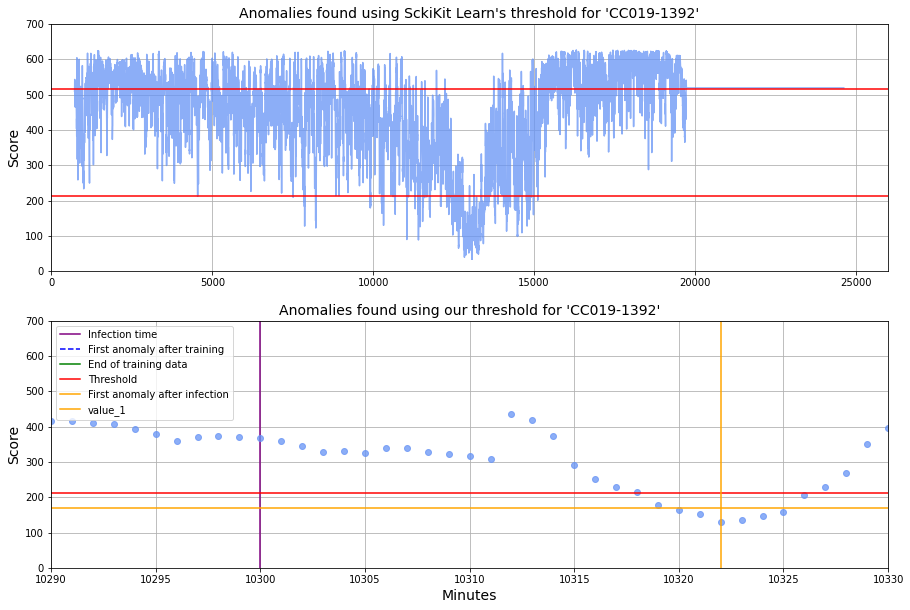

In [55]:
fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
fig.set_facecolor("white")

train_end = 4320
shift = 2*360 # since the period is 6 hours (360) and we do this twice


for i in range(3, 4): #df_temp.shape[1]
    ax[0].cla()  # clear axis 0-1
    ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    # Filing in missing data
    temp_value_fw = temp_value.fillna(method='ffill') # foward fill
    temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill
    
    # Time Delay Embedding
    temp_tde = tde.tde(temp_value_bw) # using the tde file
    temp_tde = temp_tde.T # transporting the data
    
    # Fit the Data on the first 3 days (3*24*60) 
    model.fit(temp_tde[:4321,:])
    
    # Predict the Data
    predict_train_data = model.predict(temp_tde[:4321,:]) # predict on training data
    predict_test_data = model.predict(temp_tde[4321:,:]) # predicting on test data
    
    # Scores
    scores_train_data = model.score_samples(temp_tde[:4321,:]) # scores on training data 
    scores_test_data = model.score_samples(temp_tde[4321:,:]) # scores on test data
    
    threshold = model.offset_
    # Combine training and testing scores and predictions
    combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
    combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)
    
    time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift
    
    # Minimum score
    min_score = scores_train_data.min()
    
    ##################################################################
    # Plotting
    ax[0].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
    ax[0].grid()
    ax[0].set_ylabel("Score", fontsize=14)
    ax[0].set_title(f"Anomalies found using SckiKit Learn's threshold for '{names}'", fontsize=14)
    ax[0].set_xlim(-10,26000)
    ax[0].set_ylim(0,700)
    ax[0].axhline(y = threshold, color='red', linestyle='-', label='threshold')
   
    # Find the indices of the anomalies
    anomaly_indices = np.where(combined_predictions==-1)[0] #finding the values where its -1 (anomaly)
    time_2 = anomaly_indices + (shift) # shifting the time for plotting
    
    # Plot the anomalies with red color
    #ax[0].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #[:100]
    #ax[0].axhline(y=min_score, color='red', linestyle='-')

    
    
    ##################################################################
    # Plotting infection time
    
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        # Add a vertical line at the infection time
        ax[1].axvline(x = infection_time, color='purple', linestyle='-', label='Infection time')
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
    else:
        print(f"No match found for mouse '{names}'")
        
    #ax[1].axvspan(0,infection_time, color='#8A9A5B', alpha=0.3)
    
  
    
    ##################################################################
    # Find the index at which the first score is less than min_score
    boolean = combined_scores < min_score
    anom_train = np.argmax(boolean) #+shift
    anom_infec = np.argmax(boolean[infection_time:]) + infection_time 
    
    

    
    # Get the corresponding value
    value = combined_scores[anom_train]
    value_1 = combined_scores[anom_infec]
    
    #anom_train_ind = anom_train + 1 #since index starts at 0
    #anom_infec_ind = anom_infec + 1
    
    #print("Mouse: ", names)
    print("Minimum Score: ", min_score)
    print("After Training Min: ", anom_train+shift)
    print("After Infection Min: ", anom_infec)
    
    #print(f"Time of first anomaly after training  {index} with score of {value} ")
    #print(f"Time of first anomaly after infection: {index_1} with score of {value_1}")
    ax[1].plot(time, combined_scores, 'o', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
    ax[1].grid()
    ax[1].set_ylabel("Score", fontsize=14)
    ax[1].set_xlabel("Minutes", fontsize=14)
    #new_name = df_temp.columns.astype(str).str.split(' ').str[0]
    ax[1].set_title(f"Anomalies found using our threshold for '{names}'", fontsize=14)
    ax[1].set_xlim(infection_time-10,infection_time+30)
    #ax[1].set_xlim(-10,26000)
    ax[1].set_ylim(0,700)

    ax[1].axvline(x = anom_train+shift, color='blue', linestyle='--', label='First anomaly after training') # when the first value is less the minimum value
    ax[1].axvline(x = train_end, color='green', linestyle='-', label='End of training data')
    ax[0].axhline(y=min_score, color='red', linestyle='-', label='Threshold')
    ax[1].axhline(y=min_score, color='red', linestyle='-', label='Threshold')
    ax[1].axvline(x = anom_infec, color='orange', linestyle ='-', label='First anomaly after infection')
    #ax[1].axhline(y=value, color='blue', linestyle='--', label='value')
    ax[1].axhline(y=value_1, color='orange', linestyle='-', label='value_1')
    ax[1].legend()
    time_aft_train = (anom_train + shift) - train_end
    time_aft_infection = anom_infec - infection_time
    
    print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
    print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
    
   

In [12]:
anom_infec

9602

In [49]:
combined_scores[16]

501.66571685246964

In [ ]:
boolean[10319]

In [58]:
combined_scores[10318]

356.92074095201826

In [ ]:
anom_infec

In [ ]:
min_score

In [56]:
index = np.where(combined_scores==169.1454392088167)
index

(array([10322]),)

In [ ]:
value_1

In [ ]:
10320-shift

In [ ]:
len(boolean)-10300

In [ ]:
len(boolean1)

In [ ]:
random_bool_array = np.random.choice([True, False], size=10)
random_bool_array

In [ ]:
abc = 5

In [ ]:
random_bool_array[abc:]

In [ ]:
d1 = np.argmax(random_bool_array[abc:])+abc
d1